### Capstone - Project Definition

### Lawrence Huang

##### Instructions
Assume the 591 attributes represent different sensors readings across the manufacturing process. 

Using the SECOM dataset, create a new notebook, and perform each of the following tasks and answer the related questions:

1. Refine your data understanding and prepare a DFD of solving the manufacturing quality problem
2. Read and merge data
3. Clean and prepare data 
4. Visually explore data
5. Handle class imbalance problem
6. Apply feature selection techniques to reduce dimensionality of data
7. What are your initial findings? Describe them in a summary section

##### 1. DFD of solving the manufacturing quality problem
In this potential use case, the model could be used for real-time or just-in-time identification of bad quality products, enabling their removal from the manufacturing process early on, thus saving time and downstream resources. 

For example, the model could predict product pass/fail at stage 1 of the manufactering process, based on current sensor readouts from stage 1. (In diaper manufacturing, for example, stage 1 would be the formation of the absorbent pad.) Products classified as fail at stage 1 will not move on to subsequent stages.

<img src="https://drive.google.com/uc?id=1Q1iPEPfq_GqNt7_DBItf1FhWVVO5Mo91" alt="DFD image file could not display" width="800" align="left">

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, RFE, RFECV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
%matplotlib inline

##### 2. Read and merge data

In [2]:
# load data: SECOM manufacturing Data Set from UCI Machine Learning Repository
filename_features = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
df = pd.read_csv(filename_features, header=None, sep=' ')
filename_label = 'http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df_label = pd.read_csv(filename_label, header=None, sep= ' ', usecols=[0]) # don't need label timestamp

# merge data: add label to features
df['label'] = df_label

# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(1567, 591)


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


##### 3. Clean and prepare data 

In [3]:
# identify zero variance columns with constant/single value 
cols_zero_var = df.loc[:, df.nunique()==1].columns.values
print('Columns with single value:\n{}'.format(cols_zero_var))
print('\n# columns with single value: {}'.format(len(cols_zero_var)))
# drop zero variance columns with constant/single value 
df.drop(cols_zero_var, axis=1, inplace=True)

Columns with single value:
[5 13 42 49 52 69 97 141 149 178 179 186 189 190 191 192 193 194 226 229
 230 231 232 233 234 235 236 237 240 241 242 243 256 257 258 259 260 261
 262 263 264 265 266 276 284 313 314 315 322 325 326 327 328 329 330 364
 369 370 371 372 373 374 375 378 379 380 381 394 395 396 397 398 399 400
 401 402 403 404 414 422 449 450 451 458 461 462 463 464 465 466 481 498
 501 502 503 504 505 506 507 508 509 512 513 514 515 528 529 530 531 532
 533 534 535 536 537 538]

# columns with single value: 116


In [4]:
# handle null/missing values
# examine data type: all numeric
print('data type:')
print(df.dtypes.value_counts())

# number of missing values: some columns are missing > 90% of values
num_missing = df.isna().sum()
print('\n# missing values/ # of columns:')
print(num_missing.value_counts().sort_index())

data type:
float64    474
int64        1
dtype: int64

# missing values/ # of columns:
0       53
1       80
2       84
3       20
4        9
5        3
6       57
7       20
8       12
9       15
10       4
12       4
14      16
24      38
51       8
260     12
273      8
715      4
794      4
949      4
1018    12
1341     4
1429     4
dtype: int64


In [5]:
# drop columns missing >50%
cols_excess_missing = num_missing[num_missing>df.shape[0]/2].index.to_list()
print('\nColumns with >50% missing values:\n{}'.format(cols_excess_missing))
print('\n# columns with >50% missing values: {}'.format(len(cols_excess_missing)))
df.drop(cols_excess_missing, axis=1, inplace=True)


Columns with >50% missing values:
[72, 73, 85, 109, 110, 111, 157, 158, 220, 244, 245, 246, 292, 293, 345, 346, 358, 382, 383, 384, 492, 516, 517, 518, 578, 579, 580, 581]

# columns with >50% missing values: 28


In [6]:
# impute other columns with missing values
# strategy: fill with median or 0. Trying median here.
print('# missing values before imputation: {}'.format(df.isna().sum().sum()))
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# imputer = SimpleImputer(missing_values=np.nan, strategy='constant') # fill with 0
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
print('# missing values after imputation: {}'.format(df.isna().sum().sum()))

# missing values before imputation: 10868
# missing values after imputation: 0


In [7]:
# find columns with near-zero variance, with conditions 1 and 2:
# 1. few (<10%) unique values relative to the number of samples 
# 2. large ratio (>19, or >95:5%) of the frequency of the most common value to the frequency of the second most common value
top2 = (df.apply(lambda x: pd.Series(x.value_counts().values[:2]))).T
cols_nzv = df.columns[(df.nunique()/df.shape[0]<0.1) & (top2[0]/top2[1]>19)].to_list()
print('columns with near-zero variance:\n{}'.format(cols_nzv))
print('\n# columns with near-zero variance: {}'.format(len(cols_nzv)))
# drop columns with near-zero variance
df.drop(cols_nzv, axis=1, inplace=True)

columns with near-zero variance:
[74, 114, 206, 209, 249, 342, 347, 387, 478, 521, 542]

# columns with near-zero variance: 11


In [8]:
# view cleaned and preprocessed dataframe
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(1567, 436)


,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.0205,0.0148,0.0046,71.9005,-1.0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1.0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1.0
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1.0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1.0


##### 4. Visually explore data

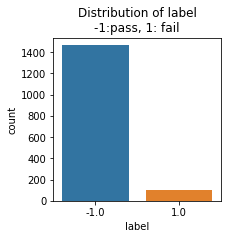

fail rate: 6.6%


In [9]:
# plot distribution of label; check for imbalanced classes
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x='label', data=df, ax=ax)
plt.title('Distribution of label\n-1:pass, 1: fail')
plt.show()
print('fail rate: {:.1f}%'.format(100*df['label'].value_counts()[1]/len(df['label'])))

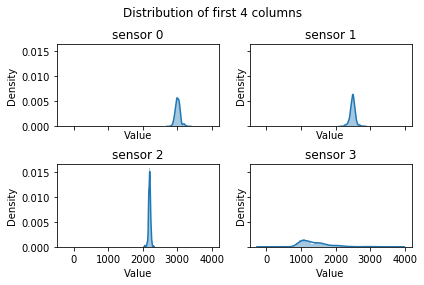

In [10]:
# plot distribution of first 4 columns
fig, axs = plt.subplots(2,2, sharey=True, sharex=True)
sns.distplot(df[0], ax=axs[0,0])
axs[0,0].set_title('sensor 0')
sns.distplot(df[1], ax=axs[0,1])
axs[0,1].set_title('sensor 1')
sns.distplot(df[2], ax=axs[1,0])
axs[1,0].set_title('sensor 2')
sns.distplot(df[3], ax=axs[1,1])
axs[1,1].set_title('sensor 3')
for ax in axs.reshape(-1):
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
fig.suptitle('Distribution of first 4 columns') 
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

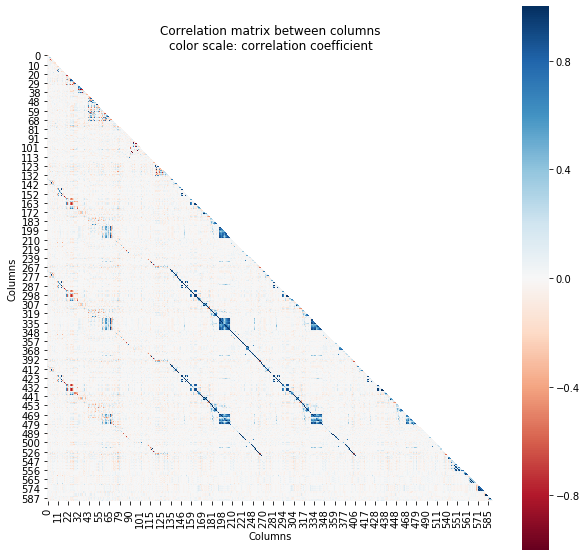

Observations: Many groups of highly correlated columns.


In [11]:
# examine correlation between columns
corrmat = df.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.heatmap(corrmat, mask=mask, vmin=-1, vmax=1, annot=False, square=True, cmap='RdBu', fmt='.2f', ax=ax)
ax.set_title('Correlation matrix between columns\ncolor scale: correlation coefficient')
ax.set_xlabel('Columns')
ax.set_ylabel('Columns')
plt.show()
print('Observations: Many groups of highly correlated columns.')

In [12]:
# find pairs with highest correlations (abs corr coeff>0.8)
corrmat = df.corr().abs()
np.fill_diagonal(corrmat.values, np.nan)
corr_series = corrmat.unstack()
corr_series_ordered = corr_series.sort_values(ascending=False)
print('First 20 pairs with the highest correlation:\n(variable 1, variable 2, correlation coeff)\n')
print(corr_series_ordered[corr_series_ordered>0.8][::2].head(20))
print('\nNumber of pairs with correlation > 0.8: {}'.format(len(corr_series_ordered[corr_series_ordered>0.8][::2])))

First 20 pairs with the highest correlation:
(variable 1, variable 2, correlation coeff)

34   36     1.000000
140  275    1.000000
172  174    1.000000
309  307    0.999999
152  287    0.999997
252  390    0.999991
275  4      0.999976
4    140    0.999975
251  389    0.999939
583  585    0.999890
176  447    0.999887
389  523    0.999857
540  268    0.999837
523  251    0.999837
520  248    0.999732
147  282    0.999596
448  177    0.999537
187  459    0.999528
283  148    0.999522
446  175    0.999483
dtype: float64

Number of pairs with correlation > 0.8: 562


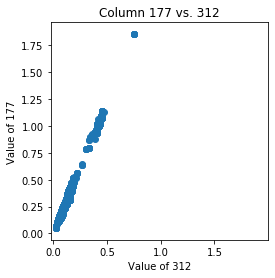

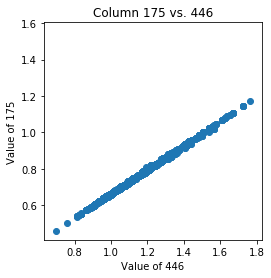

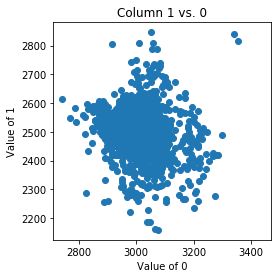

In [13]:
# plot scatterplots between selected columns
def my_scatter(col1, col2):
    plt.scatter(df[col1], df[col2])
    plt.title('Column {} vs. {}'.format(col2, col1))
    plt.xlabel('Value of {}'.format(col1))
    plt.ylabel('Value of {}'.format(col2))
    plt.axis('square')
    plt.show()
    
my_scatter(312, 177) # strongly correlated
my_scatter(446, 175) # strongly correlated
my_scatter(0, 1) # not strongly correlated

In [14]:
# models such as logistic regression and support vector classifier with linear kernel may be affected by multicollinearity 
# drop one of the pairs with correlation > 0.8
# not implemented here, will use feature selection techniques below to select features
if False:
    temp = corr_series_ordered[corr_series_ordered>0.8][::2]
    temp.index = [tuple(sorted(temp.index[xx])) for xx in range(len(temp))]
    cols_high_corr = list(set([temp.index[xx][0] for xx in range(len(temp))]))
    dfcopy = df.copy() # make a copy before dropping correlated columns
    df.drop(cols_high_corr, axis=1, inplace=True)
    
    # examine correlation between potential features
    corrmat = df.corr()
    mask = np.zeros_like(corrmat)
    mask[np.triu_indices_from(mask)] = True
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    sns.heatmap(corrmat, mask=mask, vmin=-1, vmax=1, annot=False, square=True, cmap='RdBu', fmt='.2f', ax=ax)
    ax.set_title('Correlation matrix between variables')
    plt.show()
    
    # find pairs with highest correlations 
    corrmat = df.corr().abs()
    np.fill_diagonal(corrmat.values, np.nan)
    corr_series = corrmat.unstack()
    corr_series_ordered = corr_series.sort_values(ascending=False)
    print('pairs with the highest correlation:\n(variable 1, variable 2, correlation coeff)')
    corr_series_ordered[::2].head(20)

##### 5. Handle class imbalance problem
SMOTE was used to oversample the minority class. By oversampling only on the training data, none of the information in the test data was being used to create synthetic observations. Therefore, no information will bleed from training to testing.

In [15]:
# strategy: use SMOTE on training set

# train/test split
# stratify to ensure minority class representation in both sets
y = df['label'] # label
X = df.loc[:, ~df.columns.isin(['label'])] # features, start with all but the target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=8)
print('features:\n{}'.format(X.columns.values))
print('\n# features at start: {}'.format(len(X.columns.values)))

# standardize numeric columns (z-score)
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
      
# use SMOTE to create synthetic observations of the minority class for the training set
sm = SMOTE(random_state=1) # sampling strategy = resample all classes but the majority class
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(data=X_train_res, columns=X_train.columns)
y_train_res = pd.Series(y_train_res)

print('\nLabel counts before SMOTE:')
print(y_train.value_counts())
print('\nLabel counts after SMOTE:')
print(y_train_res.value_counts())

features:
[0 1 2 3 4 6 7 8 9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47 48 50 51 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 70 71 75 76 77 78 79 80 81 82 83
 84 86 87 88 89 90 91 92 93 94 95 96 98 99 100 101 102 103 104 105 106 107
 108 112 113 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146 147 148
 150 151 152 153 154 155 156 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 180 181 182 183 184 185 187 188 195 196
 197 198 199 200 201 202 203 204 205 207 208 210 211 212 213 214 215 216
 217 218 219 221 222 223 224 225 227 228 238 239 247 248 250 251 252 253
 254 255 267 268 269 270 271 272 273 274 275 277 278 279 280 281 282 283
 285 286 287 288 289 290 291 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 316 317 318 319 320 321 323 324 331 332
 333 334 335 336 337 338 339 340 341 34

##### 6. Apply feature selection techniques to reduce dimensionality of data
<ul><li>Models will be the focus of future Milestone(s)</li>
    <li>Here, the effect of feature selection was evaluated with a support vector machine classifier using linear kernel</li>

##### No futher feature selection
Using all features after preprocessing above

In [16]:
# test using support vector classifier, linear kernel
print('# features: {}'.format(X_train_res.shape[1]))

classifier = SVC(gamma='auto', kernel='linear').fit(X_train_res, y_train_res)
print('\nClassifier: {}'.format(classifier))

# predict class labels
y_pred = classifier.predict(X_test) 

# evaluate confusion matrix
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred))

# features: 435

Classifier: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Confusion Matrix:
[[258  35]
 [ 15   6]]

TP, TN, FP, FN: 6 , 258 , 35 , 15

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.88      0.91       293
         1.0       0.15      0.29      0.19        21

    accuracy                           0.84       314
   macro avg       0.55      0.58      0.55       314
weighted avg       0.89      0.84      0.86       314



##### Select k best features based on mutual information score (Initial test: k=20)

In [17]:
# select k best features based on mutual information score
selector = SelectKBest(score_func=mutual_info_classif, k=20).fit(X_train_res, y_train_res) 
# selected features
mi_cols = X_train_res.columns[selector.get_support()].to_list()
print('selected features:\n{}'.format(mi_cols))
print('\n# selected features: {}'.format(len(mi_cols)))
X_train_mi = pd.DataFrame(selector.transform(X_train_res), columns=mi_cols)
X_test_mi = pd.DataFrame(selector.transform(X_test), columns=mi_cols)

# test using support vector classifier, linear kernel
classifier = SVC(gamma='auto', kernel='linear').fit(X_train_mi, y_train_res)
print('\nClassifier:\n{}'.format(classifier))

# predict class labels
y_pred = classifier.predict(X_test_mi) 

# evaluate confusion matrix
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred))

selected features:
[104, 121, 123, 124, 131, 143, 155, 166, 167, 219, 238, 239, 278, 288, 357, 366, 368, 376, 377, 584]

# selected features: 20

Classifier:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Confusion Matrix:
[[184 109]
 [ 10  11]]

TP, TN, FP, FN: 11 , 184 , 109 , 10

Classification report:
              precision    recall  f1-score   support

        -1.0       0.95      0.63      0.76       293
         1.0       0.09      0.52      0.16        21

    accuracy                           0.62       314
   macro avg       0.52      0.58      0.46       314
weighted avg       0.89      0.62      0.72       314



##### Select k best features based on ANOVA F-value (Initial test: k=20)

In [18]:
# select k best features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=20).fit(X_train_res, y_train_res) 
# selected features
f_cols = X_train_res.columns[selector.get_support()].to_list()
print('Selected features:\n{}'.format(f_cols))
print('\n# selected features: {}'.format(len(f_cols)))
X_train_f = pd.DataFrame(selector.transform(X_train_res), columns=f_cols)
X_test_f = pd.DataFrame(selector.transform(X_test), columns=f_cols)

# test using support vector classifier, linear kernel
classifier = SVC(gamma='auto', kernel='linear').fit(X_train_f, y_train_res)
print('\nClassifier:\n{}'.format(classifier))

# predict class labels
y_pred = classifier.predict(X_test_f) 

# evaluate confusion matrix
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred))

Selected features:
[14, 28, 59, 70, 78, 79, 103, 121, 122, 124, 125, 127, 129, 130, 183, 247, 280, 319, 455, 510]

# selected features: 20

Classifier:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Confusion Matrix:
[[213  80]
 [  8  13]]

TP, TN, FP, FN: 13 , 213 , 80 , 8

Classification report:
              precision    recall  f1-score   support

        -1.0       0.96      0.73      0.83       293
         1.0       0.14      0.62      0.23        21

    accuracy                           0.72       314
   macro avg       0.55      0.67      0.53       314
weighted avg       0.91      0.72      0.79       314



##### Sequential forward selection using mlxtend (find best between 1-60 features)

In [19]:
# test using support vector classifier, linear kernel
classifier = SVC(gamma='auto', kernel='linear')
# since SMOTE was used to handle class imbalance, the average recall on both classes was used for cross-validation scoring
sfs = SFS(classifier, k_features=(1,60), forward=True, scoring='balanced_accuracy', floating=False, cv=3,
          verbose=1, n_jobs=-1)
sfs = sfs.fit(X_train_res, y_train_res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 435 out of 435 | elapsed:   14.4s finished
Features: 1/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 434 out of 434 | elapsed:   14.3s finished
Features: 2/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 433 out of 433 | elapsed:   15.2s finished
Features: 3/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parall

[Parallel(n_jobs=-1)]: Done 407 out of 407 | elapsed:   40.8s finished
Features: 29/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 406 out of 406 | elapsed:   41.4s finished
Features: 30/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   42.3s finished
Features: 31/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 404 out of 404 | elapsed:   42.9s finished
Features: 32/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:  1.4min finished
Features: 58/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 377 out of 377 | elapsed:  1.4min finished
Features: 59/60[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 376 out of 376 | elapsed:  1.5min finished
Features: 60/60

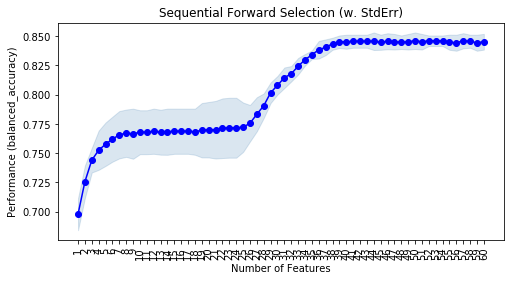

selected features:
(4, 6, 10, 19, 21, 34, 35, 36, 43, 44, 47, 56, 59, 61, 66, 101, 108, 117, 140, 144, 150, 152, 171, 172, 174, 188, 195, 199, 207, 272, 275, 287, 304, 340, 341, 343, 390, 425, 429, 433, 437, 439, 443, 445, 467, 469, 488, 543, 557, 582)

# selected features: 50

Confusion Matrix:
[[224  69]
 [  6  15]]

TP, TN, FP, FN: 15 , 224 , 69 , 6

Classification report:
              precision    recall  f1-score   support

        -1.0       0.97      0.76      0.86       293
         1.0       0.18      0.71      0.29        21

    accuracy                           0.76       314
   macro avg       0.58      0.74      0.57       314
weighted avg       0.92      0.76      0.82       314



In [20]:
# plot feature selection results
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(8,4))
plt.title('Sequential Forward Selection (w. StdErr)')
plt.ylabel('Performance (balanced_accuracy)')
plt.xticks(rotation=90)
plt.show()

# selected features
print('selected features:\n{}'.format(sfs.k_feature_names_))
print('\n# selected features: {}'.format(len(sfs.k_feature_names_)))
X_train_sfs = sfs.transform(X_train_res)
X_test_sfs = sfs.transform(X_test)
classifier.fit(X_train_sfs, y_train_res)

# predict class label
y_pred = classifier.predict(X_test_sfs)

# evaluate confusion matrix
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred))

In [21]:
# find smallest feature subset that is within 5% of the cross-validation performance
score_thr = np.max([sfs.subsets_[xx]['avg_score'] for xx in sfs.subsets_.keys()])*0.95
n_parsimonious = next(i for i,v in enumerate([sfs.subsets_[xx]['avg_score'] for xx in sfs.subsets_.keys()]) if v>score_thr)

# selected features
cols_parsimonious = list(sfs.subsets_[n_parsimonious]['feature_names'])
print('A similar (within 5%) cross-validation performance was achieved with {} features:'.format(n_parsimonious))
print('\n{}'.format(cols_parsimonious))
X_train_sfsp = X_train_res[cols_parsimonious]
X_test_sfsp = X_test[cols_parsimonious]

A similar (within 5%) cross-validation performance was achieved with 29 features:

[4, 10, 19, 34, 35, 36, 47, 56, 59, 61, 101, 108, 140, 144, 188, 195, 207, 272, 275, 287, 341, 343, 390, 425, 429, 433, 467, 543, 582]


In [22]:
# test using support vector classifier, linear kernel
classifier = SVC(gamma='auto', kernel='linear')
classifier.fit(X_train_sfsp, y_train_res)

# predict class labels
y_pred = classifier.predict(X_test_sfsp)

# evaluate confusion matrix
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[208  85]
 [  6  15]]

TP, TN, FP, FN: 15 , 208 , 85 , 6

Classification report:
              precision    recall  f1-score   support

        -1.0       0.97      0.71      0.82       293
         1.0       0.15      0.71      0.25        21

    accuracy                           0.71       314
   macro avg       0.56      0.71      0.53       314
weighted avg       0.92      0.71      0.78       314



##### Backward selection/Recursive Feature Elimination (Initial test: 20 features)

In [23]:
# test using support vector classifier, linear kernel
classifier = SVC(gamma='auto', kernel='linear')
selector = RFE(classifier, n_features_to_select=20, step=1, verbose=1).fit(X_train_res, y_train_res)

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
F

In [24]:
# selected features
rfe_cols = X_train_res.columns[selector.support_].to_list()
print('selected features:\n{}'.format(rfe_cols))
print('\n# selected features: {}'.format(len(rfe_cols)))

# predict class labels
y_pred = selector.predict(X_test) 

# evaluate confusion matrix
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred))

selected features:
[16, 59, 64, 117, 130, 132, 138, 155, 162, 201, 268, 273, 283, 297, 338, 406, 428, 477, 523, 577]

# selected features: 20

Confusion Matrix:
[[219  74]
 [ 10  11]]

TP, TN, FP, FN: 11 , 219 , 74 , 10

Classification report:
              precision    recall  f1-score   support

        -1.0       0.96      0.75      0.84       293
         1.0       0.13      0.52      0.21        21

    accuracy                           0.73       314
   macro avg       0.54      0.64      0.52       314
weighted avg       0.90      0.73      0.80       314



##### Backward selection/Recursive Feature Elimination (cross-validated selection of the best number of features)

In [25]:
# test using support vector classifier, linear kernel
classifier = SVC(gamma='auto', kernel='linear')
# since SMOTE was used to handle class imbalance, the average recall on both classes was used for cross-validation scoring
selector = RFECV(classifier, step=1, cv=StratifiedKFold(3), scoring='balanced_accuracy', verbose=1, n_jobs=-1).fit(X_train_res, y_train_res)

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.


selected features:
[0, 8, 9, 10, 12, 16, 18, 19, 21, 22, 23, 25, 26, 27, 31, 32, 38, 40, 43, 46, 50, 53, 54, 56, 57, 58, 59, 61, 62, 64, 65, 66, 67, 68, 70, 71, 76, 77, 82, 87, 89, 91, 93, 94, 99, 100, 101, 102, 104, 107, 108, 113, 116, 117, 119, 121, 124, 126, 128, 129, 130, 131, 132, 134, 136, 138, 142, 143, 145, 146, 148, 151, 152, 154, 155, 160, 161, 162, 167, 168, 171, 175, 177, 201, 202, 204, 205, 211, 214, 215, 216, 217, 218, 221, 224, 239, 248, 250, 251, 268, 269, 271, 272, 273, 277, 278, 281, 283, 286, 287, 289, 290, 291, 295, 297, 300, 302, 305, 306, 307, 309, 310, 312, 319, 321, 323, 324, 332, 334, 338, 340, 341, 343, 349, 355, 356, 357, 365, 367, 368, 388, 389, 392, 406, 407, 409, 410, 411, 412, 415, 416, 418, 421, 423, 424, 425, 428, 429, 432, 435, 436, 437, 439, 441, 446, 448, 454, 460, 468, 471, 477, 483, 486, 488, 491, 494, 496, 499, 511, 523, 539, 540, 541, 543, 547, 548, 549, 552, 554, 555, 562, 563, 571, 577, 582, 588]

# selected features: 196


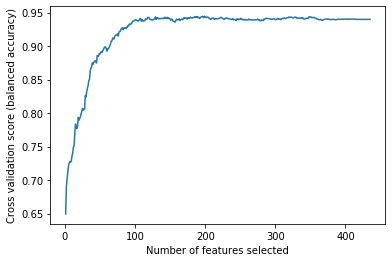


Confusion Matrix:
[[256  37]
 [ 15   6]]

TP, TN, FP, FN: 6 , 256 , 37 , 15

Classification report:
              precision    recall  f1-score   support

        -1.0       0.94      0.87      0.91       293
         1.0       0.14      0.29      0.19        21

    accuracy                           0.83       314
   macro avg       0.54      0.58      0.55       314
weighted avg       0.89      0.83      0.86       314



In [26]:
# selected features
rfe_cols = X_train_res.columns[selector.support_].to_list()
print('selected features:\n{}'.format(rfe_cols))
print('\n# selected features: {}'.format(selector.n_features_))

# plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (balanced accuracy)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# predict class labels
y_pred = selector.predict(X_test) 

# evaluate confusion matrix
print ('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred))

##### 7. What are your initial findings? Describe them in a summary section

##### Summary of initial findings:
<b>Data exploration:</b>
<ul>
    <li>Many columns are highly correlated with each other, including 500+ pairs with correlation coefficient >0.8. This multicollinary may not be ideal for models such as logistic regression or linear SVM. These highly correlated columns could still contribute to classification and was thus not excluded automatically; instead, feature selection techniques were used to further reduce dimensionality</li>
    <li>Many columns were missing >50% of values (>90% in some columns) Columns with >50% missing values were dropped, as their utility was limited</li>
    <li>Many columns had a single value (zero-variance) and werd not predictive, indicating potential problems with the corresponding sensors that engineers may need to check</li>
    <li>Labels were imbalanced, with fail rate of 6.6%; SMOTE was used to oversample the minority class in the training data</li>
</ul>

<b>Feature selection:</b>
<ul>
    <li>The following feature selection techniques were used to reduce dimensionality of the data:
        <ul>
    <li>Filtering methods: based on Mutual information score or ANOVA F-value between label/feature</li>
    <li>Wrapper methods: including forward and backward selection</li>
        </ul>
    </li>
    <li>All tested feature selection techniques reduced model complexity (decreased # features) and resulted in comparable, if not improved performance (as judged by recall of the minority class) compared to using all 400+ features after preprocessing. <br>Tested strategies include:
        <ul>
            <li>20 selected features by Mutual information or by ANOVA F-value</li>
            <li>50 selected features by forward selection (which was the best model when searching between 1-60 features). Interestingly, the smallest feature subset that was within 5% of the cross-validation performance of the 50-feature model was a set of 29 features. Recall on the minority class was the same for 50 features and 29 features, but true negative was higher and false positive was lower when using 50 features</li>
            <li>20 selected features by backward selection (RFE)</li>
            <li>RFE with cross-validated selection of the best number of features selected a large number of features (196), and its performance was comparable to (not better than) using 400+ features. Here, feature selection may have been influenced by the SMOTE-oversampled training set. While this large feature subset gave a good cross-validated score on the balanced train set, it produced a relatively worse score on the imbalanced test set.</li>
            <li>Automatically selecting for the best model using mlxtend.sequentialfeatureselector was computationally expensive and was not tested here</li>
        </ul>
    </li>
    <li>Classification results presented here may be improved by model tuning or using other models, which will be explored in future milestones</li>
</ul>